# Project Setup

In [1]:
# Load Standard Modules
import pandas as pd 
import numpy as np
import warnings
import os
import pathlib

# Plotting Modules
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

# Modeling Modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras_tuner as kt
from tensorflow.keras.losses import BinaryCrossentropy

# Evaluation Modules
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

In [2]:
warnings.filterwarnings("ignore")

# Project Topic

This is a Kaggle Project for Histopathologic Cancer Detection. I will be using a CNN to try and identify metastatic cancer in small image patches taken from lrage digital pathology scans. This is a binary classification problem.

# Data Load and Prep

In [3]:
# Load the Labels
labels =  pd.read_csv('/kaggle/input/histopathologic-cancer-detection/train_labels.csv', dtype={'id': 'str'})

In [4]:
# Load the images
train_path = '/kaggle/input/histopathologic-cancer-detection/train'
test_path = '/kaggle/input/histopathologic-cancer-detection/test'
train_dir = pathlib.Path(train_path).with_suffix('')
test_dir = pathlib.Path(test_path).with_suffix('')

In [5]:
# Get training and testing files
train_files = os.listdir(train_dir)
test_files = os.listdir(test_dir)

print('Training image files: ')
print(train_files[:10])
print('Testing image files: ')
print(test_files[:10])

Training image files: 
['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif', '5a32933e093185f5fc91d30fc83ad571c6818d25.tif', '42e77d193e73811e0bb65a0cbd9b01c5c27900fa.tif', '27bb898f54a0b9345f6c4a9083299e4465860861.tif', '89cd55e4300440612347c38f306da688a166fd40.tif', 'cd600f77aa2af7c93dc6cd836e44edada3d8c403.tif']
Testing image files: 
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif', 'd23c66547f4a00555a174d2fcb860ae399b66edc.tif', 'fabf2fca23f71655974767e29eda86a9b2c97a72.tif', '9730b15862516b8641b9f0ff48db660d95031c32.tif', 'ee85348c0950c2e639776fb555e3452c1f8437c0.tif', 'ef12a0813c504d2d1b2ba485e78d380ad64a0622

# EDA

#### Inspect Labels

In [6]:
# Take a look
labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [7]:
# dimensions
labels.shape

(220025, 2)

In [8]:
# Check for any missing values
labels.isnull().sum()

id       0
label    0
dtype: int64

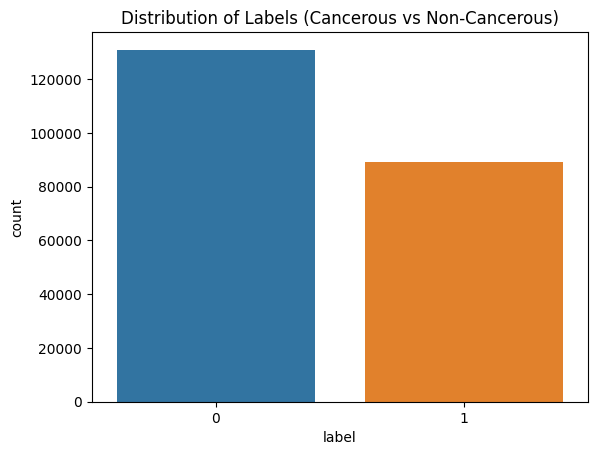

In [9]:
# Look at the distribution
sns.countplot(x='label', data=labels)
plt.title("Distribution of Labels (Cancerous vs Non-Cancerous)")
plt.show()

#### Inspect Images

In [10]:
# Function to load an image given its ID
def load_image(image_id, train_dir=train_dir):
    img_path = os.path.join(train_dir, image_id + '.tif')
    return np.array(Image.open(img_path))

# Display sample images
def display_samples(df, label, n=5):
    sample_ids = df[df['label'] == label].sample(n)['id']
    plt.figure(figsize=(12, 8))
    for i, image_id in enumerate(sample_ids):
        plt.subplot(1, n, i+1)
        img = load_image(image_id)
        plt.imshow(img)
        plt.axis('off')
    plt.suptitle(f"{'Cancerous' if label == 1 else 'Non-Cancerous'} Samples", size=16)
    plt.show()

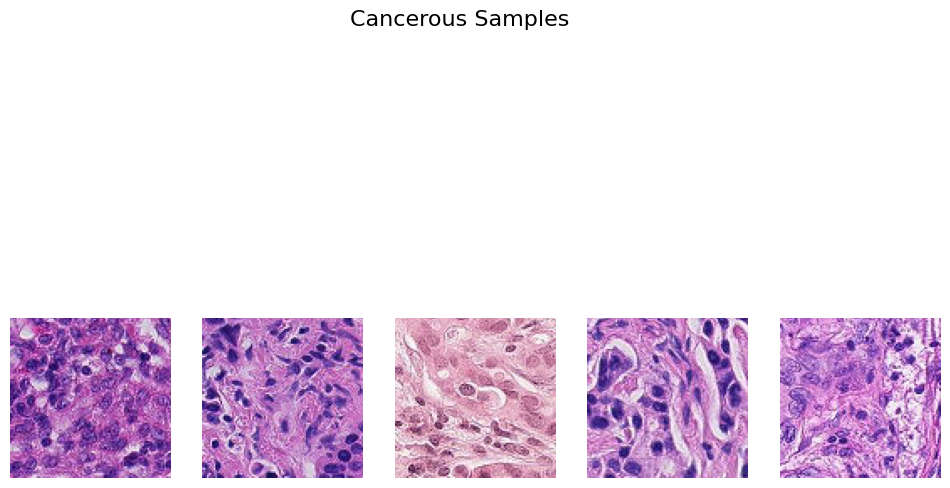

In [11]:
# Display cancerous samples
display_samples(labels, label=1)

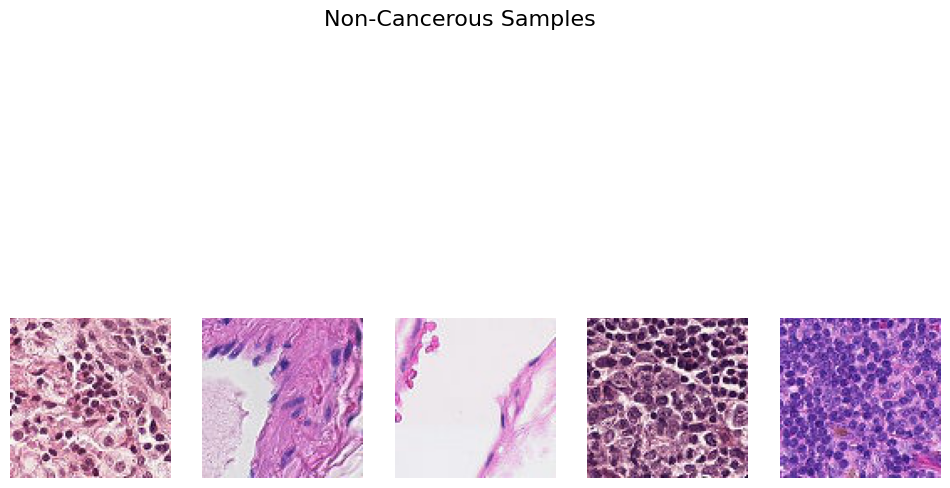

In [12]:
# Display non-cancerous samples
display_samples(labels, label=0)

**After inspecting the data, there is no data cleaning and prep necessary. The images in both classes look good and there isn't too much of a class imbalance to warrant and upsampling or downsampling.**

# Model Architecture

## First Architecture

#### Create Model

In [13]:
def create_cnn_model(input_shape=(32, 32, 3)):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(
        filters=32,  # Fixed number of filters
        kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Block
    model.add(Conv2D(
        filters=64,  # Fixed number of filters
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(
        units=64,  # Fixed number of units in Dense layer
        activation='relu'
    ))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.001),  # Fixed learning rate
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model

# Now you can create and summarize the model with default values
cnn_model = create_cnn_model()
cnn_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
cnn_model = create_cnn_model()
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 30, 30, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 166,977 (652.25 KB)

 Trainable params: 166,977 (652.25 KB)

 Non-trainable params: 0 (0.00 B)

#### Data Preprocessing

In [15]:
# Fixing data type for label
labels['label'] = labels['label'].astype(str)
labels['id'] = labels['id'] + '.tif'

In [16]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

# Load train data 
train_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir ,
    x_col="id",
    y_col="label",
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='training'
)

# Load validation
validation_generator = train_datagen.flow_from_dataframe(
    dataframe=labels,
    directory=train_dir,
    x_col="id",
    y_col="label",
    target_size=(32, 32),
    batch_size=32,
    class_mode='binary',
    subset='validation'
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


#### Model Training

In [17]:
history = cnn_model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=1, 
    verbose=1
)

5501/5501 ━━━━━━━━━━━━━━━━━━━━ 1280s 232ms/step - accuracy: 0.7688 - loss: 0.4870 - val_accuracy: 0.8088 - val_loss: 0.4193


#### Evaluate Model

In [18]:
y_pred = cnn_model.predict(validation_generator)
y_pred_classes = (y_pred > 0.5).astype("int32")

# labels
y_true = validation_generator.classes

# Confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)
print("Confusion Matrix:")
print(cm)

# Classification report
report = classification_report(y_true, y_pred_classes)
print("Classification Report:")
print(report)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 74s 53ms/step
Confusion Matrix:
[[16473  9760]
 [11177  6595]]
Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.63      0.61     26233
           1       0.40      0.37      0.39     17772

    accuracy                           0.52     44005
   macro avg       0.50      0.50      0.50     44005
weighted avg       0.52      0.52      0.52     44005



1376/1376 ━━━━━━━━━━━━━━━━━━━━ 70s 51ms/step


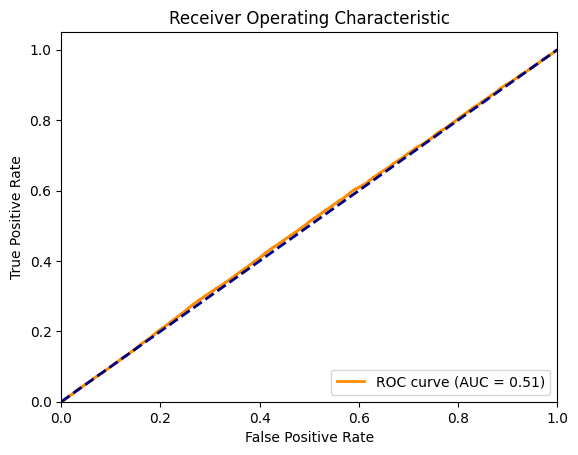

In [19]:
from sklearn.metrics import roc_curve, auc

# Get the predicted probabilities for the positive class
y_pred_prob = cnn_model.predict(validation_generator)

# Compute ROC curve and AUC
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

#### Hyperparameter Tuning

In [20]:
# Build a CNN Model
def create_cnn_model_hp(hp, input_shape=(32, 32, 3)):
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(
        filters=hp.Int('filters_1', min_value=16, max_value=64, step=16),  # Tunable filters
        kernel_size=(3, 3),
        activation='relu',
        input_shape=input_shape
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Second Convolutional Block
    model.add(Conv2D(
        filters=hp.Int('filters_2', min_value=32, max_value=128, step=32),  # Tunable filters
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D((2, 2)))
    
    # Flatten and Dense Layers
    model.add(Flatten())
    model.add(Dense(
        units=hp.Int('units_dense', min_value=32, max_value=128, step=32),  # Tunable Dense units
        activation='relu'
    ))
    
    # Output Layer
    model.add(Dense(1, activation='sigmoid'))  # Binary classification
    
    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),  # Tunable learning rate
        loss=BinaryCrossentropy(),
        metrics=['accuracy']
    )
    
    return model


In [21]:
tuner = kt.RandomSearch(
    create_cnn_model_hp,  
    objective='val_accuracy',  
    max_trials=1,       
    executions_per_trial=1,  
    directory='tuner_dir',  
    project_name='cnn_tuning'  
)

tuner.search(
    train_generator,
    validation_data=validation_generator,
    epochs=1  
)


Trial 1 Complete [00h 10m 13s]
val_accuracy: 0.8204067945480347

Best val_accuracy So Far: 0.8204067945480347
Total elapsed time: 00h 10m 13s


In [22]:
# Get the best hyperparameters
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

In [23]:
# Retrain the model
best_model = tuner.hypermodel.build(best_hp)

In [24]:
y_pred_tuned = best_model.predict(validation_generator)
y_pred_classes_tuned = (y_pred_tuned > 0.5).astype("int32")

# labels
y_true = validation_generator.classes

# Confusion matrix
cm_tuned = confusion_matrix(y_true, y_pred_classes_tuned)
print("Confusion Matrix Tuned:")
print(cm_tuned)

# Classification report
report = classification_report(y_true, y_pred_classes_tuned)
print("Classification Report Tuned:")
print(report)

1376/1376 ━━━━━━━━━━━━━━━━━━━━ 75s 54ms/step
Confusion Matrix Tuned:
[[ 4280 21953]
 [ 2975 14797]]
Classification Report Tuned:
              precision    recall  f1-score   support

           0       0.59      0.16      0.26     26233
           1       0.40      0.83      0.54     17772

    accuracy                           0.43     44005
   macro avg       0.50      0.50      0.40     44005
weighted avg       0.51      0.43      0.37     44005



## Discussion

The original model, without hyperparameter tuning slightly outperformed the tuned model. This could be for a few reasons:
* The tuned model overfitting to the train set
* Not enough trials in the tuning
* Poorly chosen hyperparameter search space

In future iterations I would like to try more hyperparameter tuning with more trials and a larger search space. 

## Submission

In [25]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=pd.DataFrame({'id': os.listdir(test_dir)}),  
    directory=test_dir,
    x_col="id", 
    y_col=None,  
    target_size=(32, 32),
    batch_size=32,
    class_mode=None,  
    shuffle=False 
)

Found 57458 validated image filenames.


In [ ]:
predictions = cnn_model.predict(test_generator, steps=test_generator.samples)

  477/57458 ━━━━━━━━━━━━━━━━━━━━ 4:15:59 270ms/step

In [ ]:
filenames = test_generator.filenames
ids = [filename.split('.')[0] for filename in filenames]
predicted_labels = (predictions > 0.5).astype(int).reshape(-1)

submission_df = pd.DataFrame({
    'id': ids,
    'label': predicted_labels
})

# Save submission.csv
submission_df.to_csv('submission_cnn_model.csv', index=False)